## Contradictory, My Dear Watson

### Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

E0000 00:00:1719918982.778208      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="localhost"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0702 11:16:22.786758390      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0702 11:16:22.786774850      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0702 11:16:22.786778232      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0702 11:16:22.786780690      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0702 11:16:22.786783023      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [3]:
df_train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
df_test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


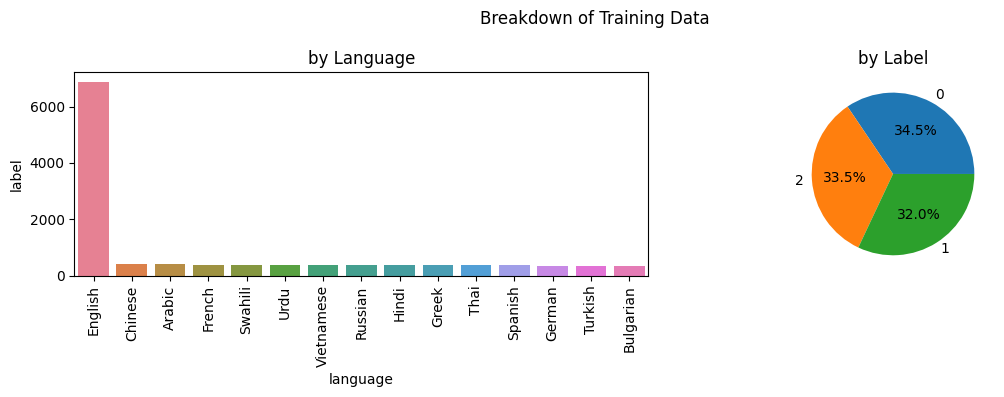

In [4]:
fig, axs = plt.subplots(figsize= (12,4), ncols= 2, nrows= 1)

dt_language = df_train.groupby("language")['label'].count().sort_values(ascending= False).reset_index()
# dt_language.loc[dt_language.label < (0.03*df_train.shape[0]), "language"] = "Other"
# dt_language = dt_language.groupby("language")['label'].sum().sort_values(ascending= False).reset_index()
sns.barplot(data= dt_language, x= "language", y= "label", hue= "language", ax= axs[0])
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
axs[0].set_title("by Language")

axs[1].pie(df_train["label"].value_counts(), autopct='%1.1f%%', labels= df_train["label"].value_counts().index);
axs[1].set_title("by Label")

plt.suptitle("Breakdown of Training Data");
plt.tight_layout();

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

In [6]:
# setting up a TPU
# TODO: connect to a cloud TPU later. Currently, generates error and uses CPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

I0000 00:00:1719919019.415887      13 service.cc:145] XLA service 0x5949998e60c0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719919019.415938      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1719919019.415943      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1719919019.415946      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1719919019.415950      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1719919019.415953      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1719919019.415955      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1719919019.415958      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1719919019.415961      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [7]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

encode_sentence("I love machine learning!")

[146, 16138, 21432, 26901, 106, 102]

In [27]:
import numpy as np
max_len= 200
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor()[:,:max_len],
      'input_mask': input_mask[:,:max_len],
      'input_type_ids': input_type_ids[:,:max_len]}

  return inputs

In [28]:
train_input = bert_encode(df_train.premise.values, df_train.hypothesis.values, tokenizer)
test_input = bert_encode(df_test.premise.values, df_test.hypothesis.values, tokenizer)

In [29]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [30]:
with strategy.scope():
    model = build_model()
    model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                            

In [31]:
history = model.fit(train_input, df_train.label.values, epochs = 5, verbose = 1, 
                    batch_size = 64, validation_split = 0.2)

Epoch 1/5


2024-07-02 11:27:54.562456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
I0000 00:00:1719919677.406207     771 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9aa29b8b5d3a2654:0:0), session_name()
I0000 00:00:1719919710.684620     771 tpu_compile_op_common.cc:245] Compilation of 9aa29b8b5d3a2654:0:0 with session name  took 33.278366164s and succeeded
I0000 00:00:1719919710.791977     771 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9aa29b8b5d3a2654:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_12680087104538752291", property.function_library_fingerprint = 14402130127142805026, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1,

151/152 [============================>.] - ETA: 0s - loss: 0.9924 - accuracy: 0.5030

I0000 00:00:1719919728.314196     793 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(715933c1d400aa92:0:0), session_name()
I0000 00:00:1719919759.705267     793 tpu_compile_op_common.cc:245] Compilation of 715933c1d400aa92:0:0 with session name  took 31.391020679s and succeeded
I0000 00:00:1719919759.794985     793 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(715933c1d400aa92:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_12680087104538752291", property.function_library_fingerprint = 14402130127142805026, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,200,;4,200,;4,200,;4,;", property.guaranteed_constants_size = 0, emb

152/152 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.5028

2024-07-02 11:29:30.675827: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1719919771.431533     837 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(253f6bd057d58ebb:0:0), session_name()
I0000 00:00:1719919776.171531     837 tpu_compile_op_common.cc:245] Compilation of 253f6bd057d58ebb:0:0 with session name  took 4.739952899s and succeeded
I0000 00:00:1719919776.200048     837 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(253f6bd057d58ebb:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_3053184747935284767", property.function_library_fingerprint = 16092861107803501828, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topolog

152/152 [==============================] - 158s 469ms/step - loss: 0.9925 - accuracy: 0.5028 - val_loss: 0.8542 - val_accuracy: 0.6176
Epoch 2/5


I0000 00:00:1719919781.765230     757 tpu_compile_op_common.cc:245] Compilation of 4632a23d059cf65a:0:0 with session name  took 4.611582801s and succeeded
I0000 00:00:1719919781.795154     757 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4632a23d059cf65a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_3053184747935284767", property.function_library_fingerprint = 16092861107803501828, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,200,;7,200,;7,200,;7,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1719919781.795191     757 tpu_compilation_cache_interface.cc:541] After adding entry for key 46

152/152 [==============================] - 19s 125ms/step - loss: 0.7661 - accuracy: 0.6624 - val_loss: 0.7943 - val_accuracy: 0.6452
Epoch 3/5
152/152 [==============================] - 19s 125ms/step - loss: 0.6207 - accuracy: 0.7401 - val_loss: 0.8493 - val_accuracy: 0.6399
Epoch 4/5
152/152 [==============================] - 19s 125ms/step - loss: 0.4721 - accuracy: 0.8091 - val_loss: 0.9600 - val_accuracy: 0.6448
Epoch 5/5
152/152 [==============================] - 19s 125ms/step - loss: 0.3388 - accuracy: 0.8718 - val_loss: 1.0673 - val_accuracy: 0.6477


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


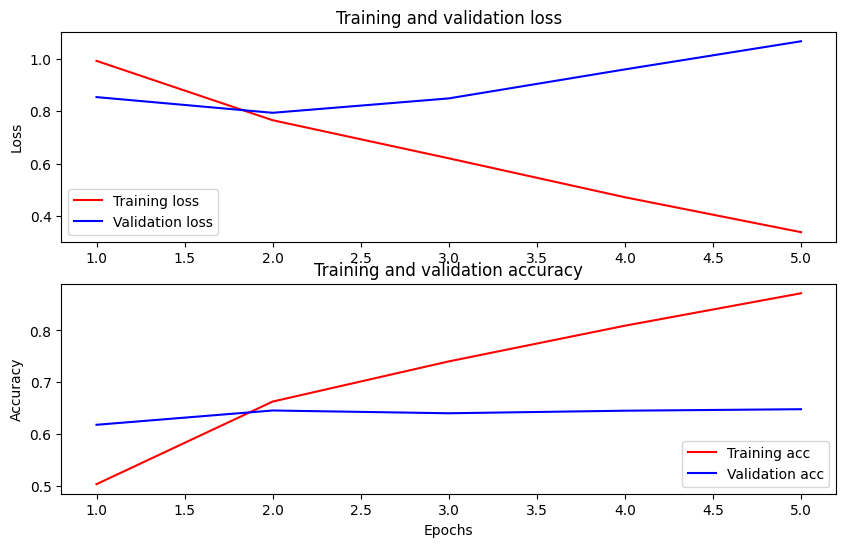

In [32]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [33]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
df_test['pred_label'] = predictions
df_test.head()

2024-07-02 11:31:08.745287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1719919869.444943     828 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(407548951a1504d2:0:0), session_name()


  7/163 [>.............................] - ETA: 3s 

I0000 00:00:1719919873.565652     828 tpu_compile_op_common.cc:245] Compilation of 407548951a1504d2:0:0 with session name  took 4.120663193s and succeeded
I0000 00:00:1719919873.590389     828 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(407548951a1504d2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15523113325979743199", property.function_library_fingerprint = 322467150769287300, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,200,;4,200,;4,200,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1719919873.590448     828 tpu_compilation_cache_interface.cc:541] After adding entry for key 407

160/163 [============================>.] - ETA: 0s

I0000 00:00:1719919876.747127     814 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(811704d1a6f574cb:0:0), session_name()


163/163 [==============================] - 22s 43ms/step


I0000 00:00:1719919880.496726     814 tpu_compile_op_common.cc:245] Compilation of 811704d1a6f574cb:0:0 with session name  took 3.749561703s and succeeded
I0000 00:00:1719919880.518335     814 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(811704d1a6f574cb:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15523113325979743199", property.function_library_fingerprint = 322467150769287300, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,200,;2,200,;2,200,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1719919880.518370     814 tpu_compilation_cache_interface.cc:541] After adding entry for key 811

,id,premise,hypothesis,lang_abv,language,pred_label
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu,2
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic,1
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French,0
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese,1
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian,0


In [34]:
submission = df_test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0


In [35]:
submission.to_csv("submission.csv", index = False)